In [1]:
#read data with format
import pandas as pd
#math calculation
import numpy as np
#sql
import sqlite3

#plot
import seaborn as sns
import matplotlib.pyplot as plt

print("Finish import libraries")

Finish import libraries


In [2]:
conn = sqlite3.connect("database.sqlite")
df = pd.read_sql_query("select * from Tweets;", conn)
print("Finish loading dataset")

Finish loading dataset


In [3]:
df['text_len'] = [len(t) for t in df['text']]

In [16]:
#clean text
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
misspell_dict = {"aren't" : "are not",
                "can't" : "cannot",
                "couldn't" : "could not",
                "didn't" : "did not",
                "doesn't" : "does not",
                "don't" : "do not",
                "hadn't" : "had not",
                "hasn't" : "has not",
                "haven't" : "have not",
                "he'd" : "he would",
                "he'll" : "he will",
                "he's" : "he is",
                "i'd" : "I would",
                "i'll" : "I will",
                "i'm" : "I am",
                "isn't" : "is not",
                "it's" : "it is",
                "it'll":"it will",
                "i've" : "I have",
                "let's" : "let us",
                "mightn't" : "might not",
                "mustn't" : "must not",
                "shan't" : "shall not",
                "she'd" : "she would",
                "she'll" : "she will",
                "she's" : "she is",
                "shouldn't" : "should not",
                "that's" : "that is",
                "there's" : "there is",
                "they'd" : "they would",
                "they'll" : "they will",
                "they're" : "they are",
                "they've" : "they have",
                "we'd" : "we would",
                "we're" : "we are",
                "weren't" : "were not",
                "we've" : "we have",
                "what'll" : "what will",
                "what're" : "what are",
                "what's" : "what is",
                "what've" : "what have",
                "where's" : "where is",
                "who'd" : "who would",
                "who'll" : "who will",
                "who're" : "who are",
                "who's" : "who is",
                "who've" : "who have",
                "won't" : "will not",
                "wouldn't" : "would not",
                "you'd" : "you would",
                "you'll" : "you will",
                "you're" : "you are",
                "you've" : "you have",
                "'re": " are",
                "wasn't": "was not",
                "we'll":" will",
                "didn't": "did not",
                "tryin'":"trying"}
misspell_pattern = re.compile(r'\b(' + '|'.join(misspell_dict.keys()) + r')\b')

def text_cleaner(text):
    clean_text = BeautifulSoup(text, 'lxml').get_text()
    clean_text = re.sub(combined_pat, '', clean_text)
    clean_text = re.sub(www_pat, '', clean_text)
    
    lower_case = clean_text.lower()
    misspell_handled = misspell_pattern.sub(lambda x: misspell_dict[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", misspell_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

cleaned_data = []

for text in df['text']:
    cleaned_data.append(text_cleaner(text))
    
df['clean_text'] = cleaned_data
df['text_len'] = [len(t) for t in df['clean_text']]
print('Finish cleaning text')

Finish cleaning text


In [5]:
df.loc[df['negativereason'] != '', 'negativereason'].unique()

array(["Can't Tell", 'Late Flight', 'Customer Service Issue',
       'Bad Flight', 'Flight Booking Problems', 'Lost Luggage',
       'Cancelled Flight', 'Flight Attendant Complaints', 'longlines',
       'Damaged Luggage'], dtype=object)

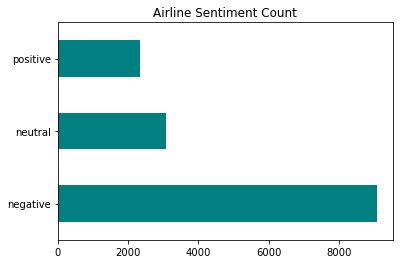

In [6]:
df['airline_sentiment'].value_counts().plot('barh', color='teal');
plt.title('Airline Sentiment Count');

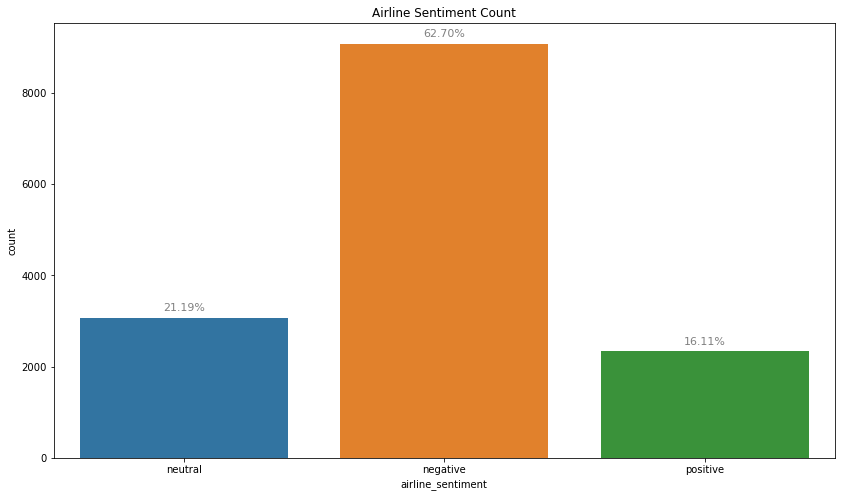

In [7]:
plt.figure(figsize=(14, 8))
g = sns.countplot(x='airline_sentiment', data=df)
plt.title('Airline Sentiment Count')
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

In [8]:
main_count = df['airline_sentiment'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'airline_sentiment'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='airline_sentiment', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'Airline Sentiment {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

In [9]:
df['airline'].unique()

array(['Delta', 'United', 'Southwest', 'US Airways', 'Virgin America',
       'American'], dtype=object)

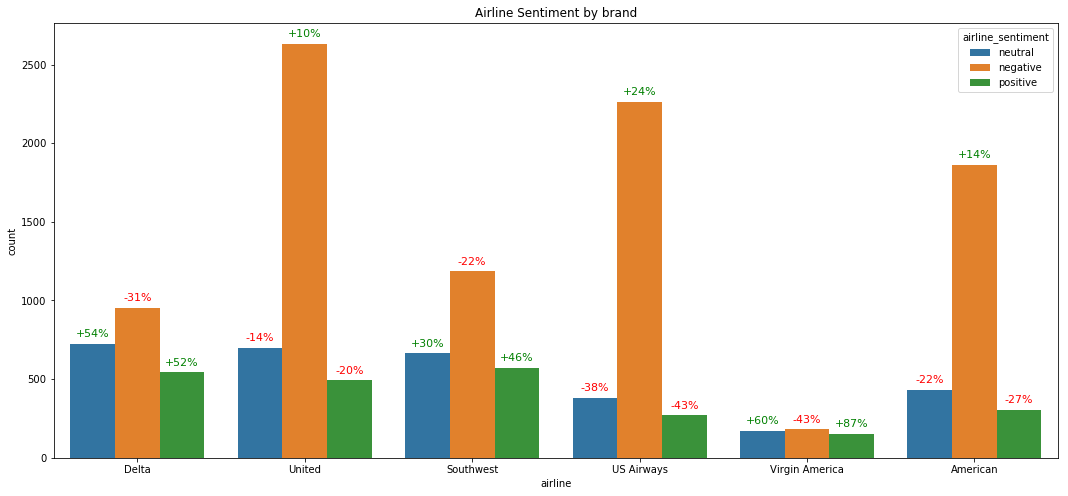

In [10]:
plt.figure(figsize=(18, 8));
make_count_plot(df=df, x='airline', title='by brand')

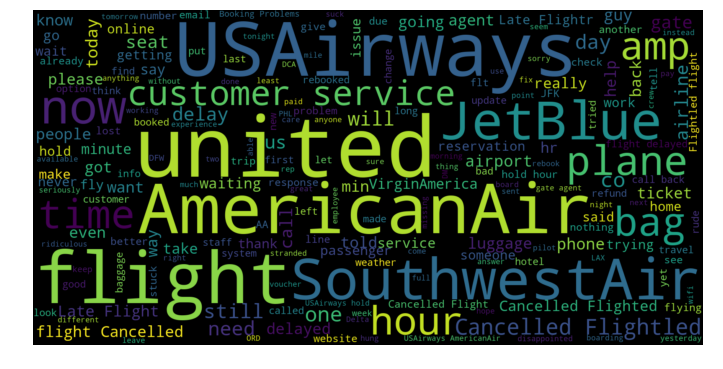

In [12]:
neg_tweets = df[df.airline_sentiment == 'negative']
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df.clean_text)

neg_matrix = cvec.transform(df[df.airline_sentiment == 'negative'].clean_text)
pos_matrix = cvec.transform(df[df.airline_sentiment != 'negative'].clean_text)
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
#possible use for tf-idf embed?
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [14]:
import nltk 
print('NLTK Version: %s' % (nltk.__version__))

#remove stopword
nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')

concat_text = ''
for row in df['clean_text']:
    concat_text += row
# print(concat_text.lower())
concat_text = concat_text.lower().split()
filtered_concat_text = [word for word in concat_text if word not in nltk_stopwords]

NLTK Version: 3.4


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brainzz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
from collections import Counter

counter = Counter(filtered_concat_text)

print(counter.most_common(10))

[('flight', 3337), ('get', 1313), ('cancelled', 987), ('service', 812), ('customer', 703), ('time', 684), ('us', 625), ('hold', 603), ('plane', 587), ('hours', 572)]
